### Importing Libraries

This cell imports necessary Python libraries for data analysis and text processing, including pandas, numpy, seaborn, matplotlib, plotly, NLTK (Natural Language Toolkit), and scikit-learn.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as plx
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn import preprocessing
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

### Loading and displaying data
In this cell, the dataset "Suicide_Detection.csv" is loaded using pandas and stored in a DataFrame called df.

In [3]:
path = "Suicide_Detection.csv"
df = pd.read_csv(path)
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


This cell checks for missing values in the dataset using df.isna().sum(). It shows the count of missing values for each column.

In [5]:
df.isna().sum()

Unnamed: 0    0
text          0
class         0
dtype: int64

### Data Labeling

This cell defines a function assignNewLabels to convert the "class" column into binary labels (1 for "suicide" and 0 for "Not Suicide"). The function is applied to the "class" column, and the modified DataFrame is displayed.

In [6]:
def assignNewLabels(label):
    if label == 'suicide' :
        return 1
    else:
        return 0
df['class'] = df['class'].apply(assignNewLabels)
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,1
1,3,Am I weird I don't get affected by compliments...,0
2,4,Finally 2020 is almost over... So I can never ...,0
3,8,i need helpjust help me im crying so hard,1
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",1


In [7]:
df = df.drop('Unnamed: 0',axis=1)

###  Data Visualization
Class Distribution:

In [8]:
df['class'].value_counts()

class
1    116037
0    116037
Name: count, dtype: int64

class
1    116037
0    116037
Name: count, dtype: int64


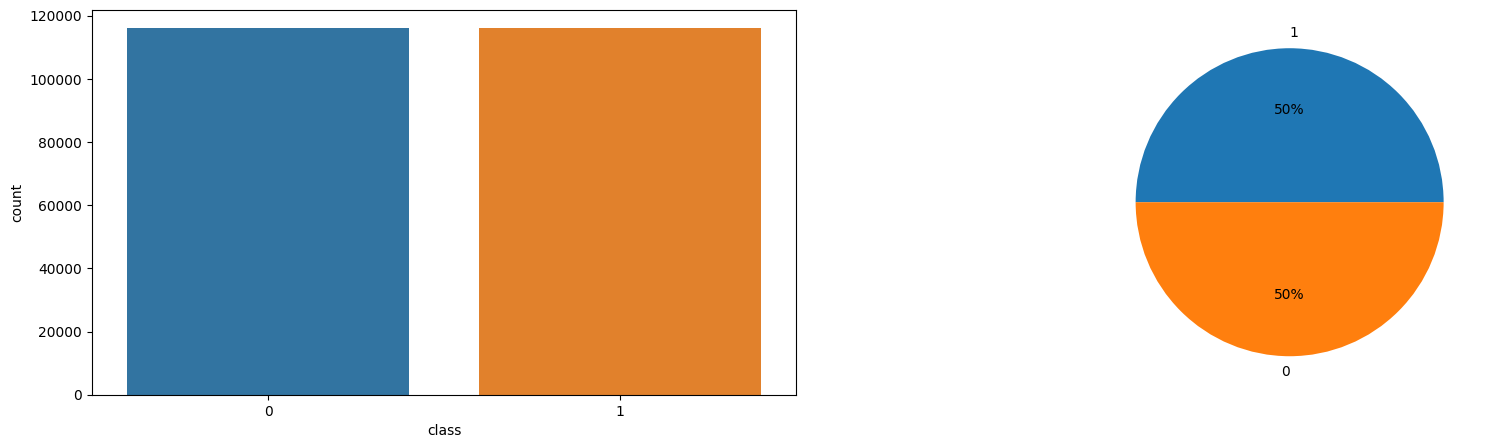

In [10]:
classCnt = df['class'].value_counts()
print(classCnt)

plt.figure(figsize=((20,5)))

plt.subplot(1,2,1)
sns.countplot(df,x='class')

plt.subplot(1,2,2)
plt.pie(classCnt,labels = classCnt.index,autopct='%.0f%%')

plt.show()

#### Text Length Analysis:
Here, the text length of each entry in the "text" column is computed and stored in a new column called "Length." Descriptive statistics of the "Length" column are displayed.

In [11]:
df['Length'] = df['text'].apply(lambda x: len(x.split(' ')))
df['Length'].describe()

count    232074.000000
mean        131.546438
std         222.081581
min           1.000000
25%          26.000000
50%          60.000000
75%         154.000000
max       15632.000000
Name: Length, dtype: float64

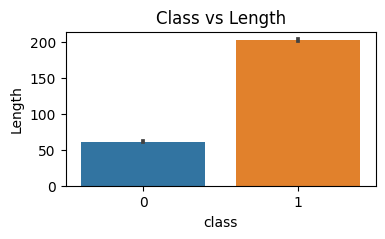

In [12]:
plt.figure(figsize=(4,2))
sns.barplot(x='class',y='Length',data=df)
plt.title('Class vs Length')
plt.show()

#### Word Frequency Analysis

This cell analyzes the frequency of words in the text data, including counting the occurrence of each word and displaying the most frequent words.

In [14]:
from collections import Counter

Words = list()
for i in df['text']:
    for j in i.split(' '):
        Words.append(j.upper())
        
Words_Freq = Counter(Words)
Words_Freq = pd.DataFrame({'Word':list(Words_Freq.keys()),'Frequency':list(Words_Freq.values())})
Words_Freq.sort_values('Frequency',ascending=False,inplace=True)
Words_Freq.head(70)

,Word,Frequency
4,I,1630930
18,TO,1018982
16,AND,881967
90,THE,669863
30,A,617833
...,...,...
421,THINK,68268
1916,I'VE,68232
116,NEVER,64959
181,ONLY,64561


In [16]:
df

,text,class,Length
0,Ex Wife Threatening SuicideRecently I left my ...,1,143
1,Am I weird I don't get affected by compliments...,0,27
2,Finally 2020 is almost over... So I can never ...,0,26
3,i need helpjust help me im crying so hard,1,9
4,"I’m so lostHello, my name is Adam (16) and I’v...",1,436
...,...,...,...
232069,If you don't like rock then your not going to ...,0,19
232070,You how you can tell i have so many friends an...,0,31
232071,pee probably tastes like salty tea😏💦‼️ can som...,0,14
232072,The usual stuff you find hereI'm not posting t...,1,366


#### Word Count Visualization

This cell contains code for visualizing the word count distribution for both "suicide" and "non-suicide" classes using histograms.

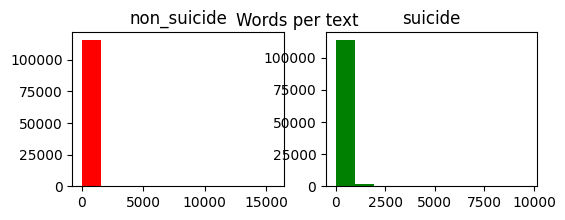

In [17]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(6,2))
train_words=df[df['class']==0]['Length']
ax1.hist(train_words,color='red')
ax1.set_title('non_suicide')
train_words=df[df['class']==1]['Length']
ax2.hist(train_words,color='green')
ax2.set_title('suicide')
fig.suptitle('Words per text')
plt.show()

### Preprocessing:
The following steps are carried out for preprocessing:\

1. Lowercasing and Punctuation Removal: The text is converted to lowercase to ensure uniformity, and punctuation is removed to eliminate non-essential characters.
2. Stopword Removal: A list of stopwords (common words like "the," "and," "in") is removed from the text to focus on content-carrying words.
3. Lemmatization: Lemmatization is applied to reduce words to their base or root form. This step involves part-of-speech tagging using NLTK and then lemmatizing each word based on its part of speech.
4. Final Text Preprocessing (Cell 15): All the preprocessing steps, including lowercasing, punctuation removal, stopword removal, and lemmatization, are combined into a final preprocessing function. This function is applied to the text data, and the cleaned and lemmatized text is stored in a new column called "clean_text."

These preprocessing steps are crucial for improving the quality of the text data, reducing dimensionality, and preparing it for various text analysis tasks such as sentiment analysis and machine learning model training. The "clean_text" column created in Cell 15 contains the processed text that can be used for subsequent analysis and modeling.

In [18]:
#convert to lowercase, strip and remove punctuations

def preprocess(text):
    text = text.lower()
    text=text.strip()
    text=re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text)
    text = re.sub(r'\s+',' ',text)
    return text

In [19]:
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

In [20]:
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [21]:
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [22]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

In [24]:
from tqdm import tqdm

tqdm.pandas()
df['clean_text'] = df['text'].progress_apply(lambda x: finalpreprocess(x))

  0%|          | 0/232074 [00:00<?, ?it/s]

100%|██████████| 232074/232074 [47:59<00:00, 80.61it/s]   


In [25]:
df.head()

,text,class,Length,clean_text
0,Ex Wife Threatening SuicideRecently I left my ...,1,143,ex wife threaten suiciderecently leave wife go...
1,Am I weird I don't get affected by compliments...,0,27,weird get affect compliment come someone know ...
2,Finally 2020 is almost over... So I can never ...,0,26,finally almost never hear bad year ever swear ...
3,i need helpjust help me im crying so hard,1,9,need helpjust help im cry hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",1,436,im losthello name adam ive struggle year im af...


#### Splitting Data: Train-Validation-Test Split

In [26]:
# Split the data into training and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(df["clean_text"], df["class"], test_size=0.3, shuffle=True)

# Split the training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=True)
X_train =  X_train.to_frame()
X_test = X_test.to_frame()
X_val = X_val.to_frame()


#### Vectorizing: 
This part of the code is responsible for vectorizing the text data using various techniques for feature representation. Here's a description of what each part of the code accomplishes:

1. Count Vectorization (CountVectorizer):
- Count Vectorization, implemented using CountVectorizer, represents text data as a matrix of word counts.
- It quantifies the frequency of each word in a document.
2. TF-IDF Vectorization (TfidfVectorizer):
- TF-IDF (Term Frequency-Inverse Document Frequency) Vectorization, achieved with TfidfVectorizer, transforms text data into numerical values.
- It emphasizes words that are important within a specific document but less common across all documents.
- Additionally, the second TfidfVectorizer (tfidf_vectorizer_n12) includes bigrams (word pairs) for capturing additional context.
3. Bag of Words (BoW) Vectorization (CountVectorizer):
- Bag of Words (BoW) Vectorization, performed using CountVectorizer, represents text data as a collection of word frequencies.
- It treats each document as a vector of word occurrences, regardless of word order.
These vectorization techniques are fundamental for preparing text data for machine learning tasks, enabling models to work with numerical input data.
4. Sentiment Analysis with VADER:
- Sentiment analysis is performed using the VADER sentiment analysis tool.
- A function named get_vader_scores is defined to calculate sentiment scores, including negative, neutral, positive, and compound scores, for each document.
- The sentiment analysis results are added to the data as additional columns ('neg_score,' 'neu_score,' 'pos_score,' 'compound').
- The 'scores' column, which contains intermediate sentiment scores, is dropped, as well as the 'clean_text' column that was used for analysis.

In [27]:
count_vectorizer = CountVectorizer()
X_train_vectors_count = count_vectorizer.fit_transform(X_train)
X_val_vectors_count = count_vectorizer.fit_transform(X_val)
X_test_vectors_count = count_vectorizer.transform(X_test)

In [29]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer_n12 = TfidfVectorizer(max_features=10000, ngram_range=(1,2))


X_tfidf_train = tfidf_vectorizer.fit_transform(X_train['clean_text'])
X_tfidf_test = tfidf_vectorizer.transform(X_test['clean_text'])
X_tfidf_val = tfidf_vectorizer.transform(X_val['clean_text'])

X_tfidf_train_n12= tfidf_vectorizer_n12.fit_transform(X_train['clean_text'])
X_tfidf_test_n12=tfidf_vectorizer_n12.transform(X_test['clean_text'])
X_tfidf_val_n12=tfidf_vectorizer_n12.transform(X_val['clean_text'])

In [ ]:
vectorizer = CountVectorizer()
X_bow_train = vectorizer.fit_transform(X_train['clean_text'])
X_bow_test = vectorizer.transform(X_test['clean_text'])
X_bow_val = vectorizer.transform(X_val['clean_text'])

In [30]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
def get_vader_scores(data):
    sid=SIA()
    vader_df=data.copy()
    vader_df['scores'] = vader_df['clean_text'].apply(lambda txt: sid.polarity_scores(str(txt)))
    vader_df['neg_score'] = vader_df['scores'].apply(lambda txt: txt['neg'])
    vader_df['neu_score'] =vader_df['scores'].apply(lambda txt: txt['neu'])
    vader_df['pos_score'] = vader_df['scores'].apply(lambda txt: txt['pos'])
    vader_df['compound'] = vader_df['scores'].apply(lambda txt: txt['compound'])
    vader_df.drop('scores', axis=1, inplace=True)
    vader_df.drop('clean_text', axis=1, inplace=True)
    return vader_df

In [32]:
X_vader_train = get_vader_scores(X_train)
X_vader_test = get_vader_scores(X_test)
X_vader_val = get_vader_scores(X_val)

#### Feature Selection with LinearSVC:

- Feature selection is performed using a Linear Support Vector Classifier (LinearSVC).
- LinearSVC is chosen because it applies an L1 norm penalty, which encourages feature sparsity by assigning zero weights to less important features.
- This technique identifies and retains the most influential features in the text data while reducing dimensionality.
- It helps enhance model efficiency and interpretability by focusing on the most relevant information while discarding less informative features.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

# We Can select any model but linearSVC has l1 norm penality which deals with sparse
lsvc = LinearSVC(C=100, penalty='l1', max_iter=500, dual=False)
lsvc.fit(X_tfidf_train, y_train)

# This function selecX_tfidf_traint the best features that has high weigh
fs = SelectFromModel(lsvc, prefit=True)
# This function redeuce X to the selected features
X_selection = fs.transform(X_tfidf_train)
X_test_selection = fs.transform(X_tfidf_test)
X_val_selection = fs.transform(X_tfidf_val)


lsvc.fit(X_tfidf_train_n12, y_train)
fs_n12 = SelectFromModel(lsvc, prefit=True)
X_selection_n12 = fs_n12.transform(X_tfidf_train_n12)
X_test_selection_n12 = fs_n12.transform(X_tfidf_test_n12)
X_val_selection_n12 = fs_n12.transform(X_tfidf_val_n12)

lsvc.fit(X_bow_train, y_train)
fs_n12 = SelectFromModel(lsvc, prefit=True)
X_selection_bow = fs_n12.transform(X_bow_train)
X_test_selection_bow = fs_n12.transform(X_bow_test)
X_val_selection_bow = fs_n12.transform(X_bow_val)

### Model Training:

#### Plots used for showing the result of different models are:
1. plot_results(data) Function:
- Visualizes model performance metrics (precision, recall, F1-score) for different text representations.
- Uses bar charts with distinct colors for each representation.
2. plot_curves(model, X, y) Function:
- Plots ROC and precision-recall curves for binary classification models.
- ROC curve assesses true positive vs. false positive trade-off.
- Precision-recall curve evaluates precision vs. recall trade-off.
3. plot_confusion_matrices(cf_matrices, model_names) Function:
- Generates a grid of subplots, each containing a confusion matrix.
- Helps assess model classification performance in multi-class scenarios.

In [37]:
import matplotlib.pyplot as plt
def plot_results(data):

    barWidth = 0.15
    # set heights of bars

    bars1 = [data[0][1],data[1][1], data[2][1]]
    bars2 = [data[0][2], data[1][2], data[2][2]]
    bars3 = [data[0][3], data[1][3], data[2][3]]
    if len(data[0]) > 4:
      bars4 = [data[0][4], data[1][4], data[2][4]]


    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    if len(data[0]) > 4:
      r4 = [x + barWidth for x in r3]


    # Make the plot
    ##FFE4C4
    ##FFAEB9
    ##87CEFA
    ##6E7B8B
    plt.bar(r1, bars1, color='#FFE4C4', width=barWidth, edgecolor='white', label='tfidf')
    plt.bar(r2, bars2, color='#FFAEB9', width=barWidth, edgecolor='white', label='tfidf_n12')
    plt.bar(r3, bars3, color='#87CEFA', width=barWidth, edgecolor='white', label='Count vectorizer')
    if len(data[0]) > 4:
      plt.bar(r4, bars4, color='#6E7B8B', width=barWidth, edgecolor='white', label='vader')
    


    # Add xticks on the middle of the group bars
    plt.xlabel('group', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(bars1))], ['precision', 'recall', 'f1-score'])

    # Create legend & Show graphic
    plt.legend()
    plt.grid()
    plt.show()

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Define a function to plot the ROC curve and precision-recall curve
def plot_curves(model, X, y):
    fig, ax = plt.subplots(figsize=(6, 3))
    # Compute predicted probabilities
    y_prob = model.decision_function(X)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)

    # Compute precision-recall curve and AP
    precision, recall, _ = precision_recall_curve(y, y_prob)
    average_precision = average_precision_score(y, y_prob)

    # Plot ROC curve and diagonal line
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")

    # Plot precision-recall curve and baseline
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label='Precision-recall curve (AP = %0.2f)' % average_precision)
    plt.plot([0, 1], [1, 0], 'k--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")

    # Show plot
    plt.tight_layout()
    plt.show()

In [2]:
def plot_confusion_matrices(cf_matrices, model_names):
    # Create grid of subplots
    num_models = len(cf_matrices)
    num_rows = (num_models + 1) // 2
    num_cols = 2
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 8))

    # Flatten the axs array for easy indexing
    axs = axs.flatten()

    for i in range(num_models):
        # Plot confusion matrix for the i-th model in the corresponding subplot
        sns.heatmap(cf_matrices[i], annot=True, cmap='Blues', ax=axs[i])
        axs[i].set_title(model_names[i], fontsize=16)

    # Remove any empty subplots
    for j in range(num_models, num_rows * num_cols):
        fig.delaxes(axs[j])

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    # Show plot
    plt.show()

#### Grid Search for Hyperparameter Tuning:
- Grid Search finds the best hyperparameter combination for a model.
- LinearSVC with dual=False is used.
- 5-fold cross-validation (cv=5) is applied to evaluate parameter sets.
- n_jobs=-1 uses all CPU cores for faster computation.
- Results, including mean test scores and parameter combos, are printed to identify the optimal settings.

#### Linear Regression:

In [77]:
from sklearn.linear_model import LinearRegression

Best hyperparameters:  {'copy_X': True, 'fit_intercept': True}\
Best score:  0.3001505748618398\
X_val_selection


Best hyperparameters:  {'copy_X': True, 'fit_intercept': True}\
Best score:  0.529826081208219\
X_val_selection_n12


Best hyperparameters:  {'copy_X': True, 'fit_intercept': True}\
Best score:  -339.3577385803191\
X_val_selection_bow


Best hyperparameters:  {'copy_X': True, 'fit_intercept': True}\
Best score:  0.1772517770991779\
X_vader_val

In [60]:
def binary_maker(arr):
    b = []
    for i in arr:
        if i>0.5:
            b.append(1)
        else:
            b.append(0)
    return b

In [ ]:
linear_r = LinearRegression(copy_X=True, fit_intercept=True)
linear_r.fit(X_selection, y_train)
y_predict_tfidf = linear_r.predict(X_test_selection)
y_predict_tfidf = binary_maker(y_predict_tfidf)

linear_r.fit(X_selection_n12, y_train)
y_predict_tfidf_n12 = linear_r.predict(X_test_selection_n12)
y_predict_tfidf_n12 = binary_maker(y_predict_tfidf_n12)

linear_r.fit(X_selection_bow, y_train)
y_predict_bow = linear_r.predict(X_test_selection_bow)
y_predict_bow = binary_maker(y_predict_bow)

linear_r.fit(X_vader_train, y_train)
y_predict_vader = linear_r.predict(X_vader_test)
y_predict_vader = binary_maker(y_predict_vader)

In [76]:
lr_tfidf_results = metrics.precision_recall_fscore_support(y_test, y_predict_tfidf)
lr_tfidf_n12_results = metrics.precision_recall_fscore_support(y_test, y_predict_tfidf_n12)
lr_bow_results = metrics.precision_recall_fscore_support(y_test, y_predict_bow)
lr_vader_results = metrics.precision_recall_fscore_support(y_test, y_predict_vader)

lr_tfidf_acc = metrics.accuracy_score(y_test, y_predict_tfidf)
lr_tfidf_n12_acc = metrics.accuracy_score(y_test, y_predict_tfidf_n12)
lr_bow_acc = metrics.accuracy_score(y_test, y_predict_bow)
lr_vader_acc = metrics.accuracy_score(y_test, y_predict_vader)


data3 = [['TF-IDF','TF-IDF 2-grams ','Count Vectorizer','vader'],
         ['precision',lr_tfidf_results[0][0],lr_tfidf_n12_results[0][0],lr_bow_results[0][0],
          lr_vader_results[0][0]],
         ['recall',lr_tfidf_results[1][0],lr_tfidf_n12_results[1][0],lr_bow_results[1][0],
          lr_vader_results[1][0]],
         ['F1-score',lr_tfidf_results[2][0],lr_tfidf_n12_results[2][0],lr_bow_results[2][0],
          lr_vader_results[2][0]],
        ['accuracy',lr_tfidf_acc,lr_tfidf_n12_acc, lr_bow_acc,
          lr_vader_acc]]

print(tabulate(data3, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════╤══════════╤═══════════════════╤════════════════════╤══════════╕
│           │   TF-IDF │   TF-IDF 2-grams  │   Count Vectorizer │    vader │
╞═══════════╪══════════╪═══════════════════╪════════════════════╪══════════╡
│ precision │ 0.908983 │          0.90687  │           0.784685 │ 0.685962 │
├───────────┼──────────┼───────────────────┼────────────────────┼──────────┤
│ recall    │ 0.947083 │          0.948545 │           0.962984 │ 0.688517 │
├───────────┼──────────┼───────────────────┼────────────────────┼──────────┤
│ F1-score  │ 0.927642 │          0.927239 │           0.86474  │ 0.687237 │
├───────────┼──────────┼───────────────────┼────────────────────┼──────────┤
│ accuracy  │ 0.92593  │          0.925369 │           0.848972 │ 0.685822 │
╘═══════════╧══════════╧═══════════════════╧════════════════════╧══════════╛


##### Plots for Linear Regression results:

Scores Plot:

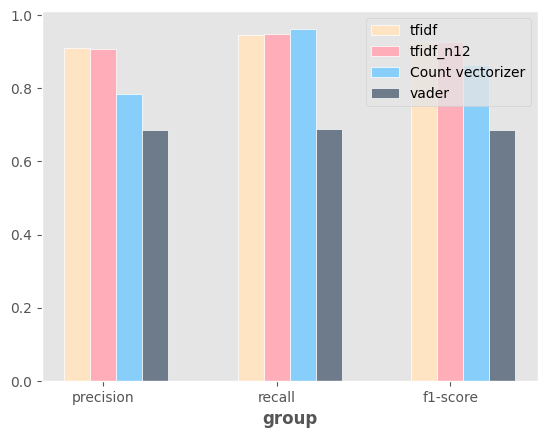

In [77]:
plot_results(data3[1:])

Confusion Matrices:

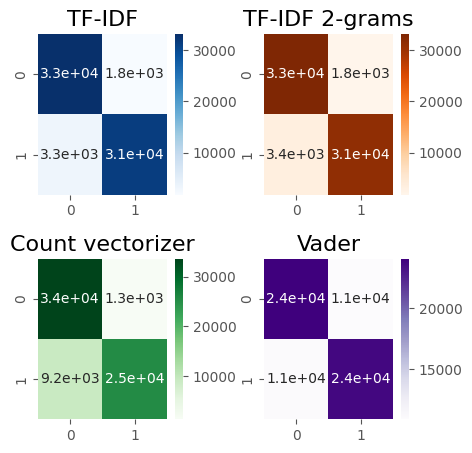

In [78]:
# Define confusion matrices and model names
cf_matrix_tfidf = confusion_matrix(y_test, y_predict_tfidf)
cf_matrix_tfidf_n12 = confusion_matrix(y_test, y_predict_tfidf_n12)
cf_matrix_bow = confusion_matrix(y_test, y_predict_bow)
cf_matrix_vader = confusion_matrix(y_test, y_predict_vader)
model_names = ['TF-IDF', 'TF-IDF 2-grams', 'Count vectorizer', 'Vader']

# Call the function to generate the subplots
cf_matrices = [cf_matrix_tfidf, cf_matrix_tfidf_n12, cf_matrix_bow, cf_matrix_vader]
plot_confusion_matrices(cf_matrices, model_names)

ROC Plots:
- tf-idf 
- tf-idf gram_range=(1,2)
- Bag Of Words
- Vader scores

/var/folders/45/jvxvzz8x0777yprw8k07jm0c0000gn/T/ipykernel_10851/3165496420.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


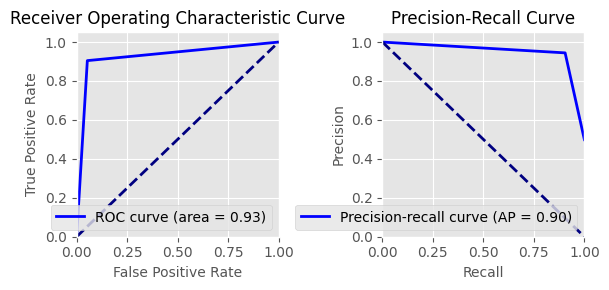

In [99]:
plot_curves(y_predict_tfidf, y_test)

/var/folders/45/jvxvzz8x0777yprw8k07jm0c0000gn/T/ipykernel_10851/3165496420.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


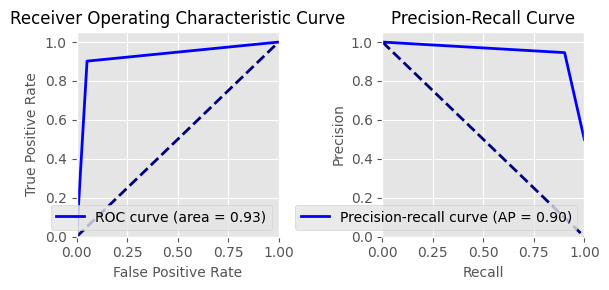

In [100]:
plot_curves(y_predict_tfidf_n12, y_test)

/var/folders/45/jvxvzz8x0777yprw8k07jm0c0000gn/T/ipykernel_10851/3165496420.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


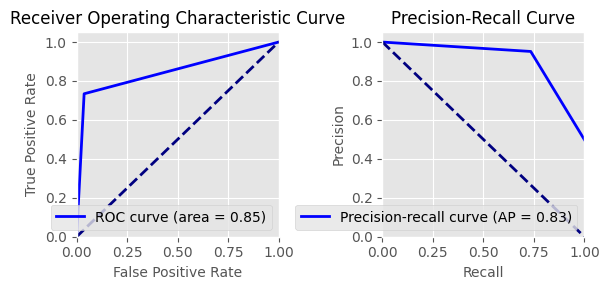

In [101]:
plot_curves(y_predict_bow, y_test)

/var/folders/45/jvxvzz8x0777yprw8k07jm0c0000gn/T/ipykernel_10851/3165496420.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


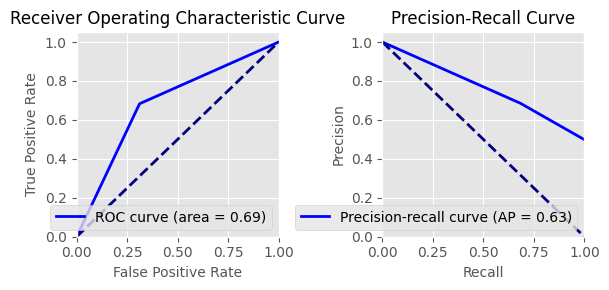

In [102]:
plot_curves(y_predict_vader, y_test)

#### Logistic regression:

Best hyperparameters:  {'C': 10, 'penalty': 'l2'}\
Best score:  0.9262565479330556\
X_val_selection


Best hyperparameters:  {'C': 10, 'penalty': 'l2'}\
Best score:  0.9260410970250839\
X_val_selection_n12

Best hyperparameters:  {'C': 1, 'penalty': 'l2'}\
Best score:  0.9197316432563364\
X_val_selection_bow


Best hyperparameters:  {'C': 0.1, 'penalty': 'l2'}\
Best score:  0.6892061145756685\
X_vader_val

In [1]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf1=LogisticRegression(C = 10, penalty =  'l2')
lr_tfidf1.fit(X_selection, y_train)
#Predict y value for test dataset
y_predict_tfidf = lr_tfidf1.predict(X_test_selection)

lr_tfidf2=LogisticRegression(C = 10, penalty =  'l2')
lr_tfidf2.fit(X_selection_n12, y_train)
y_predict_tfidf_n12 = lr_tfidf2.predict(X_test_selection_n12)

lr_tfidf3=LogisticRegression(C = 1, penalty =  'l2')
lr_tfidf3.fit(X_selection_bow, y_train)
y_predict_bow = lr_tfidf3.predict(X_test_selection_bow)

lr_tfidf4=LogisticRegression(C = 0.1, penalty =  'l2')
lr_tfidf4.fit(X_vader_train, y_train)
y_predict_vader = lr_tfidf4.predict(X_vader_test)


lr_tfidf_results=metrics.precision_recall_fscore_support(y_test, y_predict_tfidf)
lr_tfidf_n12_results=metrics.precision_recall_fscore_support(y_test, y_predict_tfidf_n12)
lr_bow_results=metrics.precision_recall_fscore_support(y_test, y_predict_bow)
lr_vader_results=metrics.precision_recall_fscore_support(y_test, y_predict_vader)


lr_tfidf_acc= metrics.accuracy_score(y_test, y_predict_tfidf)
lr_tfidf_n12_acc=accuracy_score(y_test, y_predict_tfidf_n12)
lr_bow_acc= accuracy_score(y_test, y_predict_bow)
lr_vader_acc=accuracy_score(y_test, y_predict_vader)


data3 = [['TF-IDF','TF-IDF 2-grams ','bag of words','vader'],
         ['precision',lr_tfidf_results[0][0],lr_tfidf_n12_results[0][0],lr_bow_results[0][0],
          lr_vader_results[0][0]],
         ['recall',lr_tfidf_results[1][0],lr_tfidf_n12_results[1][0],lr_bow_results[1][0],
          lr_vader_results[1][0]],
         ['F1-score',lr_tfidf_results[2][0],lr_tfidf_n12_results[2][0],lr_bow_results[2][0],
          lr_vader_results[2][0]],
        ['accuracy',lr_tfidf_acc,lr_tfidf_n12_acc, lr_bow_acc,
          lr_vader_acc]]


print(tabulate(data3,headers='firstrow',tablefmt='fancy_grid'))


╒═══════════╤══════════╤═══════════════════╤════════════════╤══════════╕
│           │   TF-IDF │   TF-IDF 2-grams  │   bag of words │    vader │
╞═══════════╪══════════╪═══════════════════╪════════════════╪══════════╡
│ precision │ 0.928228 │          0.926431 │       0.910263 │ 0.681193 │
├───────────┼──────────┼───────────────────┼────────────────┼──────────┤
│ recall    │ 0.942388 │          0.93869  │       0.946635 │ 0.690994 │
├───────────┼──────────┼───────────────────┼────────────────┼──────────┤
│ F1-score  │ 0.935254 │          0.93252  │       0.928093 │ 0.686059 │
├───────────┼──────────┼───────────────────┼────────────────┼──────────┤
│ accuracy  │ 0.935136 │          0.932465 │       0.927079 │ 0.685621 │
╘═══════════╧══════════╧═══════════════════╧════════════════╧══════════╛



##### Plots for Logistic Regression results:

Scores Plot:

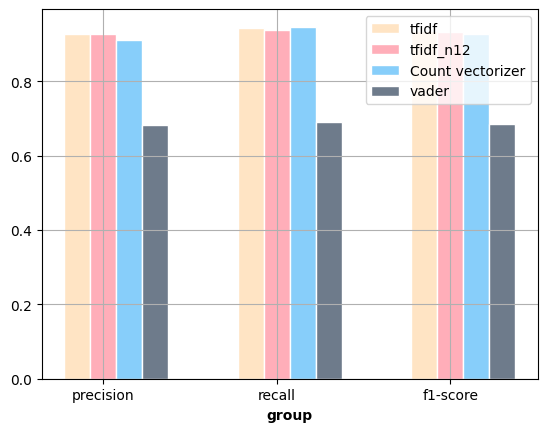

In [64]:
plot_results(data3[1:])

Confusion Matrices:

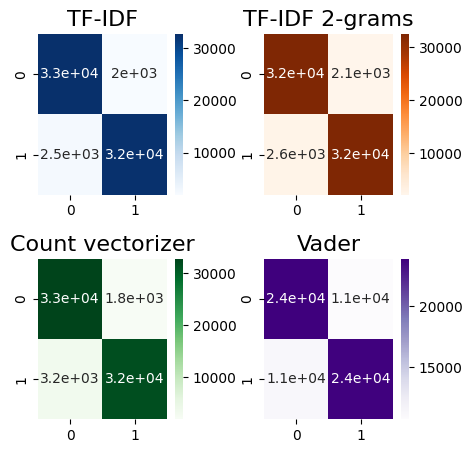

In [65]:
# Define confusion matrices and model names
cf_matrix_tfidf = confusion_matrix(y_test, y_predict_tfidf)
cf_matrix_tfidf_n12 = confusion_matrix(y_test, y_predict_tfidf_n12)
cf_matrix_bow = confusion_matrix(y_test, y_predict_bow)
cf_matrix_vader = confusion_matrix(y_test, y_predict_vader)
model_names = ['TF-IDF', 'TF-IDF 2-grams', 'Count vectorizer', 'Vader']

# Call the function to generate the subplots
cf_matrices = [cf_matrix_tfidf, cf_matrix_tfidf_n12, cf_matrix_bow, cf_matrix_vader]
plot_confusion_matrices(cf_matrices, model_names)


ROC Plots:
- tf-idf 
- tf-idf gram_range=(1,2)
- Bag Of Words
- Vader scores

/var/folders/45/jvxvzz8x0777yprw8k07jm0c0000gn/T/ipykernel_3093/187571981.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


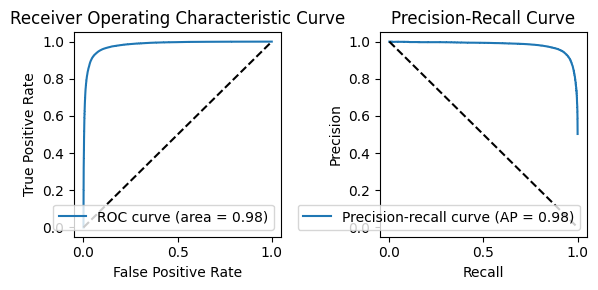

In [67]:
plot_curves(lr_tfidf1, X_test_selection, y_test)

/var/folders/45/jvxvzz8x0777yprw8k07jm0c0000gn/T/ipykernel_3093/187571981.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


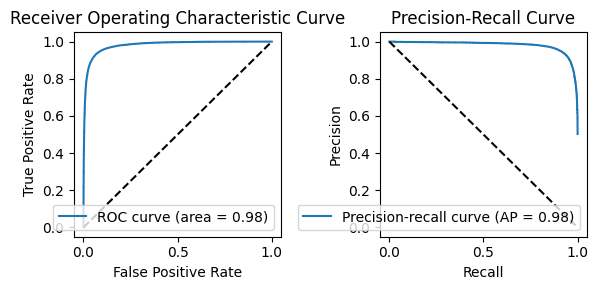

In [68]:
plot_curves(lr_tfidf2, X_test_selection_n12, y_test)

/var/folders/45/jvxvzz8x0777yprw8k07jm0c0000gn/T/ipykernel_3093/187571981.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


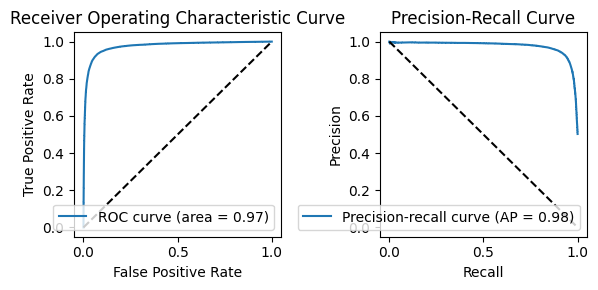

In [70]:
plot_curves(lr_tfidf3, X_test_selection_bow, y_test)

/var/folders/45/jvxvzz8x0777yprw8k07jm0c0000gn/T/ipykernel_3093/187571981.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


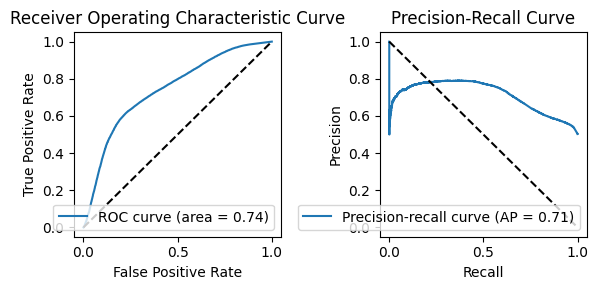

In [71]:
plot_curves(lr_tfidf4, X_vader_test, y_test)

#### SVM:

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

In [ ]:
# Define the parameter grid to search over
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2'],
              'max_iter': [500, 1000, 2000]}

# Create a LinearSVC object
lsvc = LinearSVC(dual=False)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(lsvc, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_val_selection_bow, y_val)

# Print the results for each parameter combination
results = grid_search.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print("%0.3f for %r" % (mean_score, params))


#### Best parameteres for each type of vectorization with SVM are:
Best parameters:  {'C': 1, 'max_iter': 500, 'penalty': 'l1'}\
Best score:  0.9261641265831981\
(tf-idf)

Best parameters:  {'C': 0.1, 'max_iter': 500, 'penalty': 'l2'}\
Best score:  0.9257333289573493\
X_val_selection_n12
(ti-idf2)

Best parameters:  {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1'}\
Best score:  0.6889906968190906\
(vader score)

Best parameters:  {'C': 0.1, 'max_iter': 500, 'penalty': 'l2'}\
Best score:  0.9183466159128301\
(bag of words)


In [ ]:
from sklearn import metrics

lsvc1 = LinearSVC(C=1, penalty='l1', max_iter=500, dual=False)
lsvc1.fit(X_selection, y_train)
y_predict_tfidf = lsvc1.predict(X_test_selection)

lsvc2 = LinearSVC(C=0.1, penalty='l2', max_iter=500, dual=False)
lsvc2.fit(X_selection_n12,y_train)
y_predict_tfidf_n12 = lsvc2.predict(X_test_selection_n12)

lsvc3 = LinearSVC(C=0.1, penalty='l2', max_iter=500, dual=False)
lsvc3.fit(X_selection_bow,y_train)
y_predict_bow = lsvc3.predict(X_test_selection_bow)

lsvc4 = LinearSVC(C=0.1, penalty='l1', max_iter=1000, dual=False)
lsvc4.fit(X_vader_train,y_train)
y_predict_vader = lsvc4.predict(X_vader_test)

linear_svm_tfidf_results=metrics.precision_recall_fscore_support(y_test, y_predict_tfidf)

linear_svm_tfidf_n12_results=metrics.precision_recall_fscore_support(y_test, y_predict_tfidf_n12)

linear_svm_bow_results=metrics.precision_recall_fscore_support(y_test, y_predict_bow)

vader_svm_results=metrics.precision_recall_fscore_support(y_test, y_predict_vader)

In [40]:
tfidf_acc= metrics.accuracy_score(y_test, y_predict_tfidf)
tfidf_n12_acc=accuracy_score(y_test, y_predict_tfidf_n12)
bow_acc= accuracy_score(y_test, y_predict_bow)
vader_acc=accuracy_score(y_test, y_predict_vader)

In [41]:
data1 = [['TF-IDF','TF-IDF 2-grams ','bag of words','vader'],
         ['precision',linear_svm_tfidf_results[0][0],linear_svm_tfidf_n12_results[0][0],linear_svm_bow_results[0][0],
          vader_svm_results[0][0]],
         ['recall',linear_svm_tfidf_results[1][0],linear_svm_tfidf_n12_results[1][0],linear_svm_bow_results[1][0],
          vader_svm_results[1][0]],
         ['F1-score',linear_svm_tfidf_results[2][0],linear_svm_tfidf_n12_results[2][0],linear_svm_bow_results[2][0],
          vader_svm_results[2][0]],
        ['accuracy',tfidf_acc,tfidf_n12_acc,bow_acc,
          vader_acc]]

In [42]:
from tabulate import tabulate

print(tabulate(data1,headers='firstrow',tablefmt='fancy_grid'))

╒═══════════╤══════════╤═══════════════════╤════════════════╤══════════╕
│           │   TF-IDF │   TF-IDF 2-grams  │   bag of words │    vader │
╞═══════════╪══════════╪═══════════════════╪════════════════╪══════════╡
│ precision │ 0.926687 │          0.926077 │       0.89181  │ 0.681121 │
├───────────┼──────────┼───────────────────┼────────────────┼──────────┤
│ recall    │ 0.944064 │          0.943977 │       0.956459 │ 0.692988 │
├───────────┼──────────┼───────────────────┼────────────────┼──────────┤
│ F1-score  │ 0.935295 │          0.934942 │       0.923004 │ 0.687003 │
├───────────┼──────────┼───────────────────┼────────────────┼──────────┤
│ accuracy  │ 0.935065 │          0.934691 │       0.920673 │ 0.686095 │
╘═══════════╧══════════╧═══════════════════╧════════════════╧══════════╛


##### Plots for SVM results:

Scores Plot:

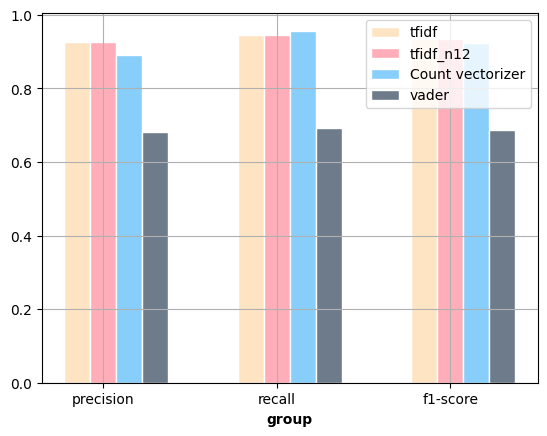

In [43]:
plot_results(data1[1:])

Confusion Matrices:

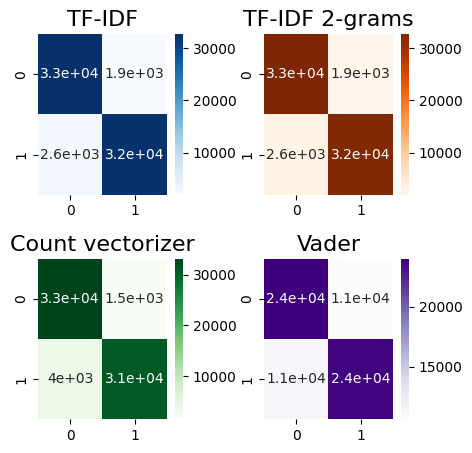

In [44]:
# Define confusion matrices and model names
cf_matrix_tfidf = confusion_matrix(y_test, y_predict_tfidf)
cf_matrix_tfidf_n12 = confusion_matrix(y_test, y_predict_tfidf_n12)
cf_matrix_bow = confusion_matrix(y_test, y_predict_bow)
cf_matrix_vader = confusion_matrix(y_test, y_predict_vader)
model_names = ['TF-IDF', 'TF-IDF 2-grams', 'Count vectorizer', 'Vader']

# Call the function to generate the subplots
cf_matrices = [cf_matrix_tfidf, cf_matrix_tfidf_n12, cf_matrix_bow, cf_matrix_vader]
plot_confusion_matrices(cf_matrices, model_names)

ROC Plots:
- tf-idf 
- tf-idf gram_range=(1,2)
- Bag Of Words
- Vader scores


/var/folders/45/jvxvzz8x0777yprw8k07jm0c0000gn/T/ipykernel_3093/187571981.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


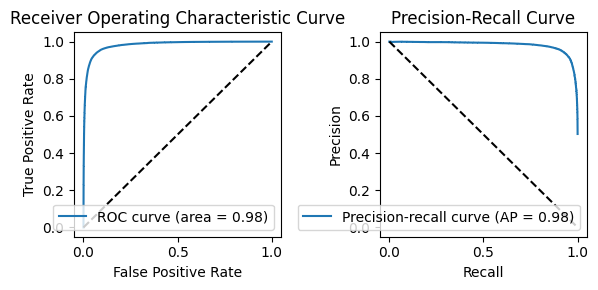

In [45]:
plot_curves(lsvc1, X_test_selection, y_test)

/var/folders/45/jvxvzz8x0777yprw8k07jm0c0000gn/T/ipykernel_3093/187571981.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


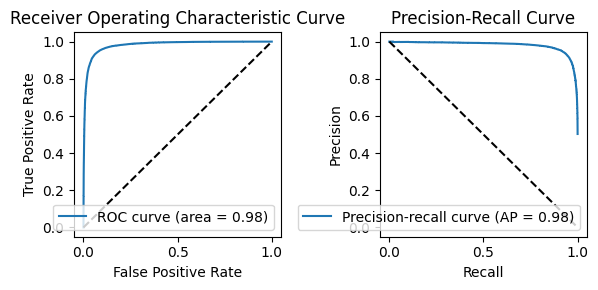

In [46]:
plot_curves(lsvc2, X_test_selection_n12, y_test)

/var/folders/45/jvxvzz8x0777yprw8k07jm0c0000gn/T/ipykernel_3093/187571981.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


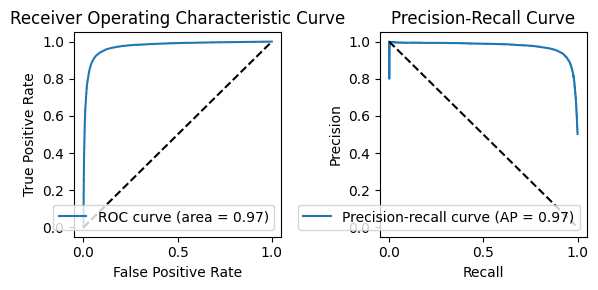

In [47]:
plot_curves(lsvc3, X_test_selection_bow, y_test)

/var/folders/45/jvxvzz8x0777yprw8k07jm0c0000gn/T/ipykernel_3093/187571981.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


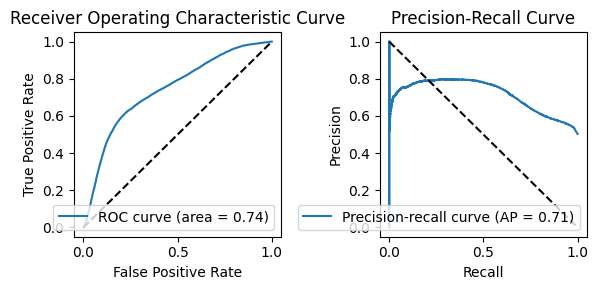

In [48]:
plot_curves(lsvc4, X_vader_test, y_test)

#### Random forest

In [81]:
def random_forrest_plot_curves(model, X, y):
    fig, ax = plt.subplots(figsize=(6, 3))
    # Compute predicted probabilities
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X)[:, 1]
    else:
        y_prob = model.decision_function(X)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)

    # Compute precision-recall curve and AP
    precision, recall, _ = precision_recall_curve(y, y_prob)
    average_precision = average_precision_score(y, y_prob)

    # Plot ROC curve and diagonal line
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")

    # Plot precision-recall curve and baseline
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label='Precision-recall curve (AP = %0.2f)' % average_precision)
    plt.plot([0, 1], [1, 0], 'k--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")

    # Show plot
    plt.tight_layout()
    plt.show()

#### Best parameteres for each type of vectorization with Random Forest are:

Best hyperparameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}\
Best score:  0.8561756807911021\
X_val_selection


Best hyperparameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}\
Best score:  0.8561449447131839\
X_val_selection_n12


Best hyperparameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}\
Best score:  0.8409406262800285\
X_val_selection_bow


Best hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}\
Best score:  0.7756611275897217\
X_vader_val

In [72]:
from sklearn.ensemble import RandomForestClassifier


clf1 = RandomForestClassifier(max_depth= 20, min_samples_leaf= 1, min_samples_split= 5, n_estimators= 200)
clf1.fit(X_selection, y_train)
y_predict_tfidf_2 = clf1.predict(X_test_selection)

clf2 = RandomForestClassifier(max_depth= 20, min_samples_leaf= 1, min_samples_split= 5, n_estimators= 100)
clf2.fit(X_selection_n12, y_train)
y_predict_tfidf_n12_2 = clf2.predict(X_test_selection_n12)

clf3 = RandomForestClassifier(max_depth= 20, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 200)
clf3.fit(X_selection_bow, y_train)
y_predict_bow_2 = clf3.predict(X_test_selection_bow)

clf4 = RandomForestClassifier(max_depth= 10, min_samples_leaf= 2, min_samples_split= 5, n_estimators= 50)
clf4.fit(X_vader_train, y_train)
y_predict_vader_2 = clf4.predict(X_vader_test)

In [51]:
RandomForest_tfidf_results=metrics.precision_recall_fscore_support(y_test, y_predict_tfidf_2)
RandomForest_tfidf_n12_results=metrics.precision_recall_fscore_support(y_test, y_predict_tfidf_n12_2)
RandomForest_bow_results=metrics.precision_recall_fscore_support(y_test, y_predict_bow_2)
RandomForest_vader_results=metrics.precision_recall_fscore_support(y_test, y_predict_vader_2)

In [52]:
RandomForest_tfidf_acc= metrics.accuracy_score(y_test, y_predict_tfidf_2)
RandomForest_tfidf_n12_acc=accuracy_score(y_test, y_predict_tfidf_n12_2)
RandomForest_bow_acc= accuracy_score(y_test, y_predict_bow_2)
RandomForest_vader_acc=accuracy_score(y_test, y_predict_vader_2)

In [53]:
data2 = [['TF-IDF','TF-IDF 2-grams ','bag of words','vader'],
         ['precision',RandomForest_tfidf_results[0][0],RandomForest_tfidf_n12_results[0][0],RandomForest_bow_results[0][0],
          RandomForest_vader_results[0][0]],
         ['recall',RandomForest_tfidf_results[1][0],RandomForest_tfidf_n12_results[1][0],RandomForest_bow_results[1][0],
          RandomForest_vader_results[1][0]],
         ['F1-score',RandomForest_tfidf_results[2][0],RandomForest_tfidf_n12_results[2][0],RandomForest_bow_results[2][0],
          RandomForest_vader_results[2][0]],
        ['accuracy',RandomForest_tfidf_acc,RandomForest_tfidf_n12_acc, RandomForest_bow_acc,
          RandomForest_vader_acc]]

In [54]:
print(tabulate(data2,headers='firstrow',tablefmt='fancy_grid'))

╒═══════════╤══════════╤═══════════════════╤════════════════╤══════════╕
│           │   TF-IDF │   TF-IDF 2-grams  │   bag of words │    vader │
╞═══════════╪══════════╪═══════════════════╪════════════════╪══════════╡
│ precision │ 0.822661 │          0.824825 │       0.801926 │ 0.771925 │
├───────────┼──────────┼───────────────────┼────────────────┼──────────┤
│ recall    │ 0.902025 │          0.901419 │       0.899656 │ 0.774869 │
├───────────┼──────────┼───────────────────┼────────────────┼──────────┤
│ F1-score  │ 0.860517 │          0.861422 │       0.847985 │ 0.773394 │
├───────────┼──────────┼───────────────────┼────────────────┼──────────┤
│ accuracy  │ 0.854631 │          0.855824 │       0.839651 │ 0.77427  │
╘═══════════╧══════════╧═══════════════════╧════════════════╧══════════╛


##### Plots for Random Forest results:

Scores Plot:

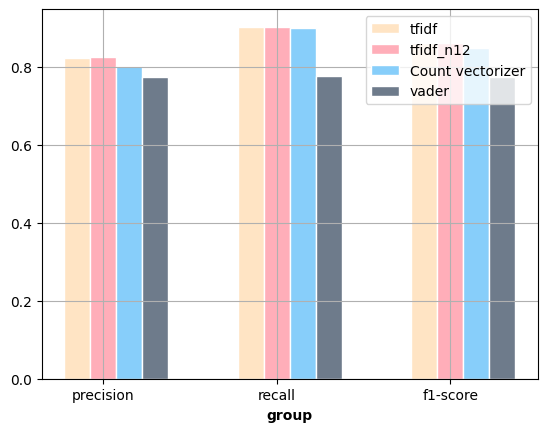

In [55]:
plot_results(data2[1:])

Confusion Matrices:

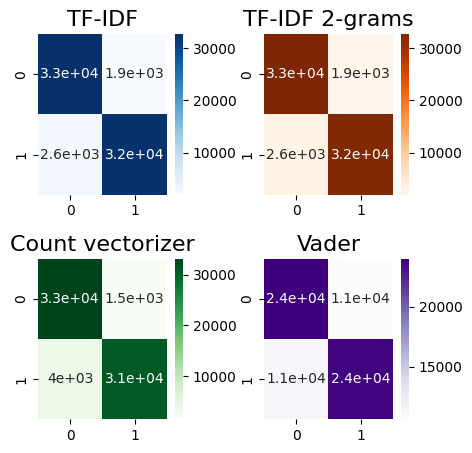

In [56]:
cf_matrix_tfidf = confusion_matrix(y_test, y_predict_tfidf)
cf_matrix_tfidf_n12 = confusion_matrix(y_test, y_predict_tfidf_n12)
cf_matrix_bow = confusion_matrix(y_test, y_predict_bow)
cf_matrix_vader = confusion_matrix(y_test, y_predict_vader)
model_names = ['TF-IDF', 'TF-IDF 2-grams', 'Count vectorizer', 'Vader']

cf_matrices = [cf_matrix_tfidf, cf_matrix_tfidf_n12, cf_matrix_bow, cf_matrix_vader]
plot_confusion_matrices(cf_matrices, model_names)

ROC Plots:
- tf-idf 
- tf-idf gram_range=(1,2)
- Bag Of Words
- Vader scores

/var/folders/45/jvxvzz8x0777yprw8k07jm0c0000gn/T/ipykernel_3093/3828603025.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


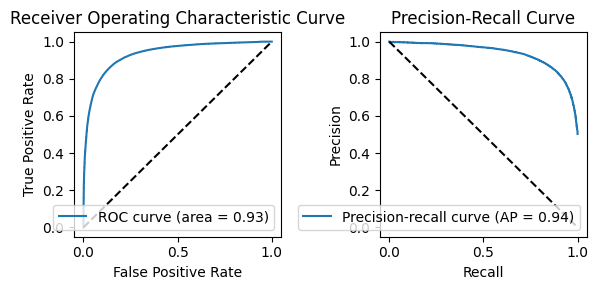

In [73]:
random_forrest_plot_curves(clf1, X_test_selection, y_test)

/var/folders/45/jvxvzz8x0777yprw8k07jm0c0000gn/T/ipykernel_3093/3828603025.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


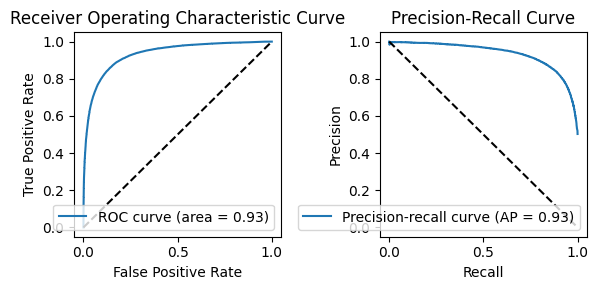

In [74]:
random_forrest_plot_curves(clf2, X_test_selection_n12, y_test)

/var/folders/45/jvxvzz8x0777yprw8k07jm0c0000gn/T/ipykernel_3093/3828603025.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


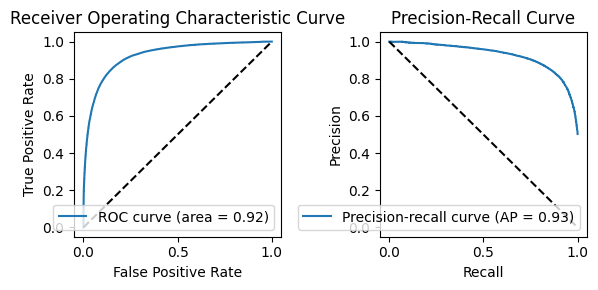

In [75]:
random_forrest_plot_curves(clf3, X_test_selection_bow, y_test)

/var/folders/45/jvxvzz8x0777yprw8k07jm0c0000gn/T/ipykernel_3093/3828603025.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


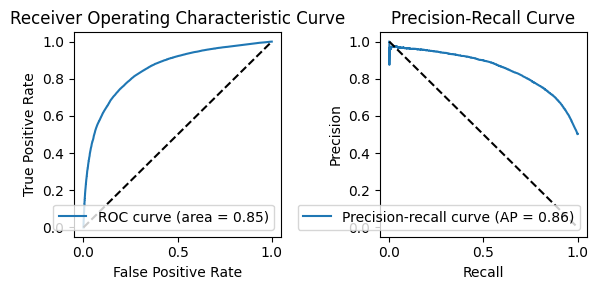

In [76]:
random_forrest_plot_curves(clf4, X_vader_test, y_test)

#### Naive Bayes:

Best hyperparameters:  {'alpha': 0.1, 'fit_prior': False}\
Best score:  0.9009571896635281\
X_val_selection


Best hyperparameters:  {'alpha': 1.0, 'fit_prior': False}\
Best score:  0.9072973605665403\
X_val_selection_n12

Best hyperparameters:  {'alpha': 0.1, 'fit_prior': False}\
Best score:  0.8956632909549596\
X_val_selection_bow


In [78]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
NB1=MultinomialNB(alpha= 0.1, fit_prior = False)
NB1.fit(X_selection, y_train)
#Predict y value for test dataset
y_predict_tfidf = NB1.predict(X_test_selection)

NB2=MultinomialNB(alpha= 1.0, fit_prior = False)
NB2.fit(X_selection_n12, y_train)
y_predict_tfidf_n12 = NB2.predict(X_test_selection_n12)

NB3=MultinomialNB(alpha= 0.1, fit_prior = False)
NB3.fit(X_selection_bow, y_train)
y_predict_bow = NB3.predict(X_test_selection_bow)



NB_tfidf_results=metrics.precision_recall_fscore_support(y_test, y_predict_tfidf)
NB_tfidf_n12_results=metrics.precision_recall_fscore_support(y_test, y_predict_tfidf_n12)
NB_bow_results=metrics.precision_recall_fscore_support(y_test, y_predict_bow)


NB_tfidf_acc= metrics.accuracy_score(y_test, y_predict_tfidf)
NB_tfidf_n12_acc=accuracy_score(y_test, y_predict_tfidf_n12)
NB_bow_acc= accuracy_score(y_test, y_predict_bow)


data4 = [['TF-IDF','TF-IDF 2-grams ','bag of words'],
         ['precision',NB_tfidf_results[0][0],NB_tfidf_n12_results[0][0],NB_bow_results[0][0]],
         ['recall',NB_tfidf_results[1][0],NB_tfidf_n12_results[1][0],NB_bow_results[1][0]],
         ['F1-score',NB_tfidf_results[2][0],NB_tfidf_n12_results[2][0],NB_bow_results[2][0]],
        ['accuracy',NB_tfidf_acc,NB_tfidf_n12_acc, NB_bow_acc]]


print(tabulate(data4,headers='firstrow',tablefmt='fancy_grid'))

╒═══════════╤══════════╤═══════════════════╤════════════════╕
│           │   TF-IDF │   TF-IDF 2-grams  │   bag of words │
╞═══════════╪══════════╪═══════════════════╪════════════════╡
│ precision │ 0.943235 │          0.940233 │       0.948345 │
├───────────┼──────────┼───────────────────┼────────────────┤
│ recall    │ 0.856491 │          0.869059 │       0.850828 │
├───────────┼──────────┼───────────────────┼────────────────┤
│ F1-score  │ 0.897773 │          0.903246 │       0.896943 │
├───────────┼──────────┼───────────────────┼────────────────┤
│ accuracy  │ 0.903035 │          0.907444 │       0.902805 │
╘═══════════╧══════════╧═══════════════════╧════════════════╛


##### Plots for Naive Bayes results:

Scores Plot:

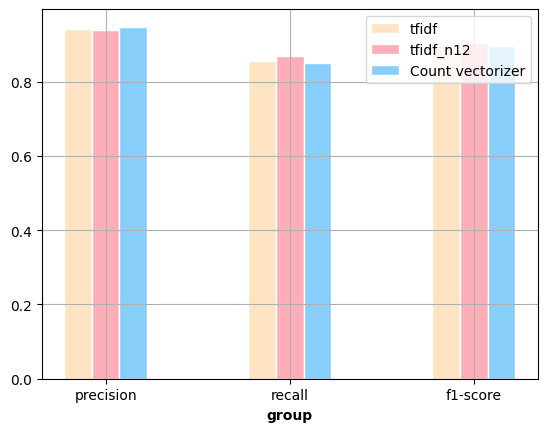

In [82]:
plot_results(data4[1:])

Confusion Matrices:

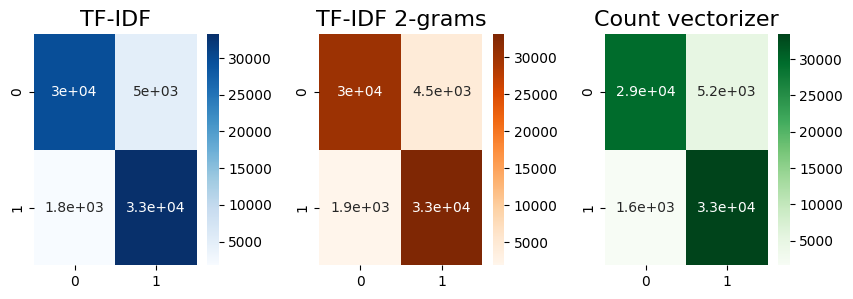

In [83]:
# Compute confusion matrices for all three models
cf_matrix_tfidf = confusion_matrix(y_test, y_predict_tfidf)
cf_matrix_tfidf_n12 = confusion_matrix(y_test, y_predict_tfidf_n12)
cf_matrix_bow = confusion_matrix(y_test, y_predict_bow)

# Create grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# Plot confusion matrix for tfidf model in first subplot
sns.heatmap(cf_matrix_tfidf, annot=True, cmap='Blues', ax=axs[0])
axs[0].set_title('TF-IDF', fontsize=16)

# Plot confusion matrix for tfidf_n12 model in second subplot
sns.heatmap(cf_matrix_tfidf_n12, annot=True, cmap='Oranges', ax=axs[1])
axs[1].set_title('TF-IDF 2-grams', fontsize=16)

# Plot confusion matrix for bow model in third subplot
sns.heatmap(cf_matrix_bow, annot=True, cmap='Greens', ax=axs[2])
axs[2].set_title('Count vectorizer', fontsize=16)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Show plot
plt.show()

ROC Plots:
- tf-idf 
- tf-idf gram_range=(1,2)
- Bag Of Words
- Vader scores

/var/folders/45/jvxvzz8x0777yprw8k07jm0c0000gn/T/ipykernel_3093/3828603025.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


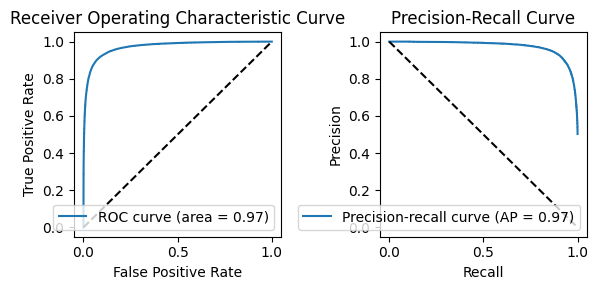

In [79]:
random_forrest_plot_curves(NB1, X_test_selection, y_test)

/var/folders/45/jvxvzz8x0777yprw8k07jm0c0000gn/T/ipykernel_3093/3828603025.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


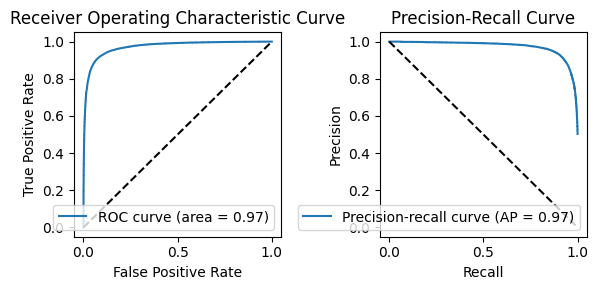

In [80]:
random_forrest_plot_curves(NB2, X_test_selection_n12, y_test)

/var/folders/45/jvxvzz8x0777yprw8k07jm0c0000gn/T/ipykernel_3093/3828603025.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


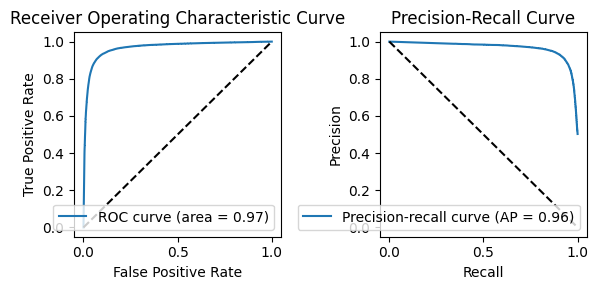

In [81]:
random_forrest_plot_curves(NB3, X_test_selection_bow, y_test)

### Model training:

### Neural Networks

In [47]:
from keras.optimizers import Adam
from keras import regularizers
from keras.models import Sequential
from keras import layers

input_dim = X_test_selection.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(64, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

optimizer = Adam(lr=0.1)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                631616    
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [ ]:
# Convert input data to dense numpy arrays
X_train_dense = X_selection.toarray()
X_test_dense = X_test_selection.toarray()

history = model.fit(X_train_dense, y_train,
                    epochs=30,
                    verbose=True,
                    validation_data=(X_test_dense, y_test),
                    batch_size=64)

In [50]:
loss, accuracy = model.evaluate(X_train_dense, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_dense, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9427
Testing Accuracy:  0.9310


In [45]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

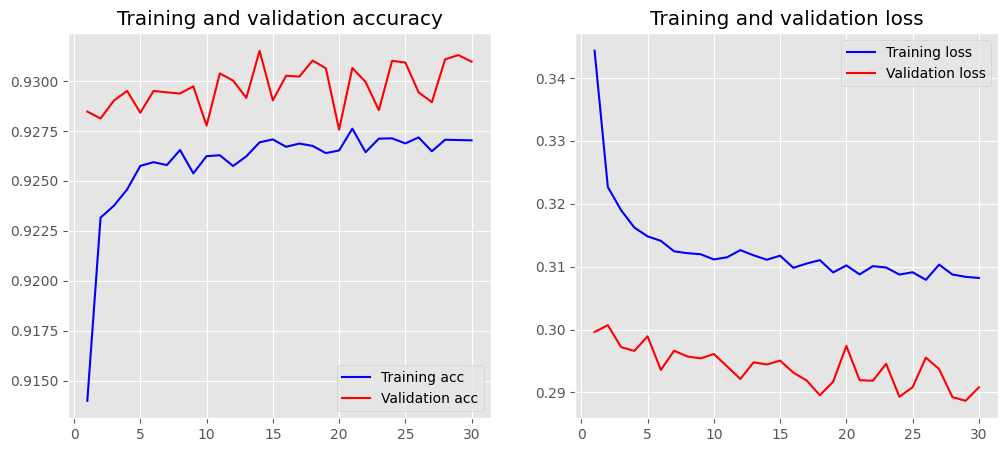

In [51]:
plot_history(history)